In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.nn.functional import interpolate

import matplotlib.pyplot as plt
import numpy as np  

import Discriminator as disc
import Generator as gen
import SequentialGenerator as sg1
import prepData as prep

# AutoEncoder fuuuu
Encoder
- input: 128 x 128
- output: 64 x 64 (or 32?)

Decoder
- input:  64 x 64
- output: 512 x 512 (or 32?)

**Work in progress**
Decoder ends up zeroing out the image somewhere after upscaling everytime.

In [28]:
batch_size = 5
N = 5
rank = 5

LR_dim = 128
HR_dim = 512
bottleneck_dim = 32


scalefactor = HR_dim/bottleneck_dim
downscalefactor = bottleneck_dim/LR_dim

### Load data

In [31]:
images=prep.load_images_from_folder('000001_01_01')
images=prep.normalize(images)
lowresimages=prep.compress_images(images)

In [41]:
len(images)

107

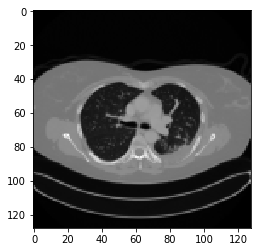

In [33]:
prep.show_img(lowresimages[19])

In [42]:
LR_loader = DataLoader(lowresimages[:20], batch_size=batch_size)#, pin_memory=cuda)
HR_loader = DataLoader(images[:20],batch_size=batch_size)#, pin_memory=cuda)

test_LR_loader = DataLoader(lowresimages[:-10], batch_size=batch_size)#, pin_memory=cuda)

### Model

In [45]:
class Autoencoder(torch.nn.Module):
    def __init__(self, layer):
        super(Autoencoder,self).__init__()

        self.encoder = gen.Generator(layer, N, rank, bottleneck_dim, bottleneck_dim, downscalefactor)
        self.decoder = gen.Generator(layer, N, rank, HR_dim, HR_dim, scalefactor)

    def forward(self, x):
        #print("Input shape = ", x.shape)
        #print(x.sum())
        x = self.encoder(x.float())
        #print("After encoder shape = ", x.shape)
        #print(x.sum())
        x = self.decoder(x)
        print("After decoder shape = ", x.shape)
        print(x.sum())
        return x

In [46]:
model = Autoencoder(gen.FTT_Layer)#.to(device)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05) #weight_decay=1e-5,)

### Training

In [48]:
epoch_loss = []
num_epochs = 2

model.train()
for epoch in range(num_epochs):
    model.train()
    #for img in LR_loader:
    for i, data in enumerate(zip(LR_loader, HR_loader)):
        batch_loss = []
        lr_img, hr_img = data
        #print(lr_img[0].sum())
        
        img = Variable(lr_img.reshape(lr_img.shape[0], 1, LR_dim, LR_dim)).float()#.to(device)
        output = model(img).float()
        #print(output.sum())

        hr_img = hr_img.reshape(hr_img.shape[0], 1, HR_dim, HR_dim).float()#.to(device)
        
        loss = loss_func(output, hr_img).float()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
        
    epoch_loss.append(np.mean(batch_loss))
    print("completed epoch {}, mean loss {}".format(epoch+1,np.mean(batch_loss)))

After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
completed epoch 1, mean loss 0.00564929936081171
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
After decoder shape =  torch.Size([5, 1, 512, 512])
tensor(0., grad_fn=<SumBackward0>)
completed epoch 2, mean loss 0.00564929936081171


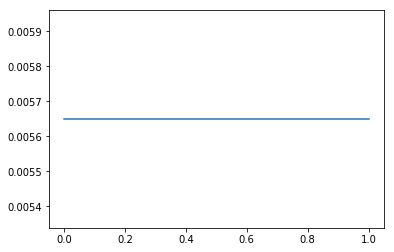

In [49]:
plt.plot(epoch_loss)
plt.show()

### Run test image through model

tensor(0., grad_fn=<SumBackward0>)


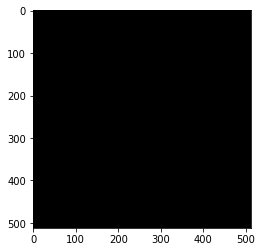

In [44]:
for img in test_LR_loader:
    img = Variable(img.reshape(img.shape[0], 1, LR_dim, LR_dim)).float()
    prep.show_img(model(img).detach().numpy()[0][0])
    break